In [1]:
from differences import ATTgt
from matplotlib import pyplot as plt
plt.rcParams["figure.dpi"] = 300
plt.rcParams['savefig.dpi'] = 300
from panel_utilities import get_value_variable_names, prepare_df_for_DiD
from stats_utilities import select_controls, test_balance, produce_summary_statistics
from figure_utilities import aggregate_by_event_time_and_plot, aggregate_by_time_and_plot
import pandas as pd



# Store paths.
analysis='group_0_crimes_500m'
INPUT_DATA = "../../data/03_cleaned/crime_analysis_monthly.parquet"
OUTPUT_FIGURES = f"../../output/group_0_crimes_warm_500m/figures"
OUTPUT_TABLES = f"../../output/group_0_crimes_warm_500m/tables"


# Read restricted sample panel dataset into memory.
df = pd.read_parquet(INPUT_DATA)

In [2]:
# Convert weekly panel to biweekly panel.
treatment_date_variable = 'latest_docket_month'
df = df.dropna(subset=treatment_date_variable)

# Generate value vars list and month to int dictionaries.
weekly_value_vars_crime, month_to_int_dictionary, int_to_month_dictionary = get_value_variable_names(df, analysis)

In [3]:
pre_pandemic_months = ['2019-05'
                       '2019-06',
                       '2019-07',
                       '2019-08',
                       '2019-09',
                       '2019-10']

df = df.loc[df['latest_docket_month'].isin(pre_pandemic_months), :]

In [4]:
covariates_exploration_df = select_controls(df=df, analysis=analysis,
                                            treatment_date_variable=treatment_date_variable,
                                            output_directory=OUTPUT_TABLES)
covariates_exploration_df

Dependent Variable  \
                                                                                             Change in Crime Incidents, April 2019-March 2020   
                                                 \emph{Independent Variable}                                                                    
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m                                      1.129008e-18   
                                                 pre_treatment_change_in_group_0_crimes_500m                                     2.992914e-43   
Panel B: Census Tract Characteristics            frac_coll_plus2010                                                              1.509305e-04   
                                                 job_density_2013                                                                7.294437e-08   
                                                 med_hhinc2016                                                                   4.290173e-04   
                                                 poor_share2010                                                                  1.464934e-03   
                                                 popdensity2010                                                                  2.111777e-04   
Panel C: Case Initiation                         for_cause                                                                       9.264922e-01   
                                                 no_cause                                                                        7.302541e-01   
                                                 non_payment                                                                     4.154359e-01   
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                                                        4.401164e-01   
                                                 hasAttyP                                                                        4.436680e-01   
                                                 isEntityD                                                                       8.839948e-02   
                                                 isEntityP                                                                       2.794272e-01   

                                                                                                               
                                                                                             Treated Property  
                                                 \emph{Independent Variable}                                   
Panel A: Pre-treatment Outcomes                  total_twenty_seventeen_group_0_crimes_500m          0.059211  
                                                 pre_treatment_change_in_group_0_crimes_500m         0.984291  
Panel B: Census Tract Characteristics            frac_coll_plus2010                                  0.755217  
                                                 job_density_2013                                    0.576266  
                                                 med_hhinc2016                                       0.159498  
                                                 poor_share2010                                      0.000059  
                                                 popdensity2010                                      0.129367  
Panel C: Case Initiation                         for_cause                                           0.009275  
                                                 no_cause                                            0.901540  
                                                 non_payment                                         0.000005  
Panel D: Defendant and Plaintiff Characteristics hasAttyD                                            0.001993  
                                                 hasAttyP                                

In [5]:
balance_table, pre_treatment_covariates = test_balance(df, analysis, covariates_exploration_df, OUTPUT_TABLES)
balance_table

\
                                             Cases Won by Plaintiff   
Panel A Total Crime Incidents, 2017                     1093.640449   
        Change in Crime Incidents, 2017-2019            -141.216292   
Panel B Bachelor's degree, 2010                            0.323187   
        Job density, 2013                              17314.676754   
        Median household income, 2016                  48646.637640   
        Poverty rate, 2010                                 0.257101   
        Population density, 2010                       22735.013758   

                                             Difference in Cases Won by Defendant  \
                                                                       Unweighted   
Panel A Total Crime Incidents, 2017                                   -104.956866   
        Change in Crime Incidents, 2017-2019                             0.340755   
Panel B Bachelor's degree, 2010                                          0.005361   
        Job density, 2013                                             1863.805551   
        Median household income, 2016                                 2739.882607   
        Poverty rate, 2010                                              -0.045703   
        Population density, 2010                                     -1783.587265   

                                                                               
                                              \emph{p}     Weighted  \emph{p}  
Panel A Total Crime Incidents, 2017           0.059211   -71.736583  0.191827  
        Change in Crime Incidents, 2017-2019  0.984291     7.706353  0.655571  
Panel B Bachelor's degree, 2010               0.755217    -0.016913  0.282002  
        Job density, 2013                     0.576266  -720.365275  0.824716  
        Median household income, 2016         0.159498 -2318.061912  0.026629  
        Poverty rate, 2010                    0.000059    -0.019342  0.009277  
        Population density, 2010              0.129367 -1444.359623  0.220863

In [6]:
# Generate indicators for missing data.

# missing_indicators = add_missing_indicators(df, ['rent_twobed2015'], pre_treatment_covariates)

# Prepare df for use with the differences package.
df = df.reset_index()
df = prepare_df_for_DiD(df=df,
                        analysis=analysis,
                        treatment_date_variable=treatment_date_variable,
                        pre_treatment_covariates=pre_treatment_covariates,
                        missing_indicators=[],
                        value_vars=weekly_value_vars_crime,
                        period_to_int_dictionary=month_to_int_dictionary)

In [7]:
# Run DiD without conditioning on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='2W', base_period='universal')
result = att_gt.fit(formula=analysis, control_group='never_treated', n_jobs=-1)

Computing ATTgt [workers=10]  100%|████████████████████| 368/368 [00:05<00:00, 68.79it/s] 


-7.310402684563758
-5.009355440766156
-4.881013613436224
-0.8695705452077526


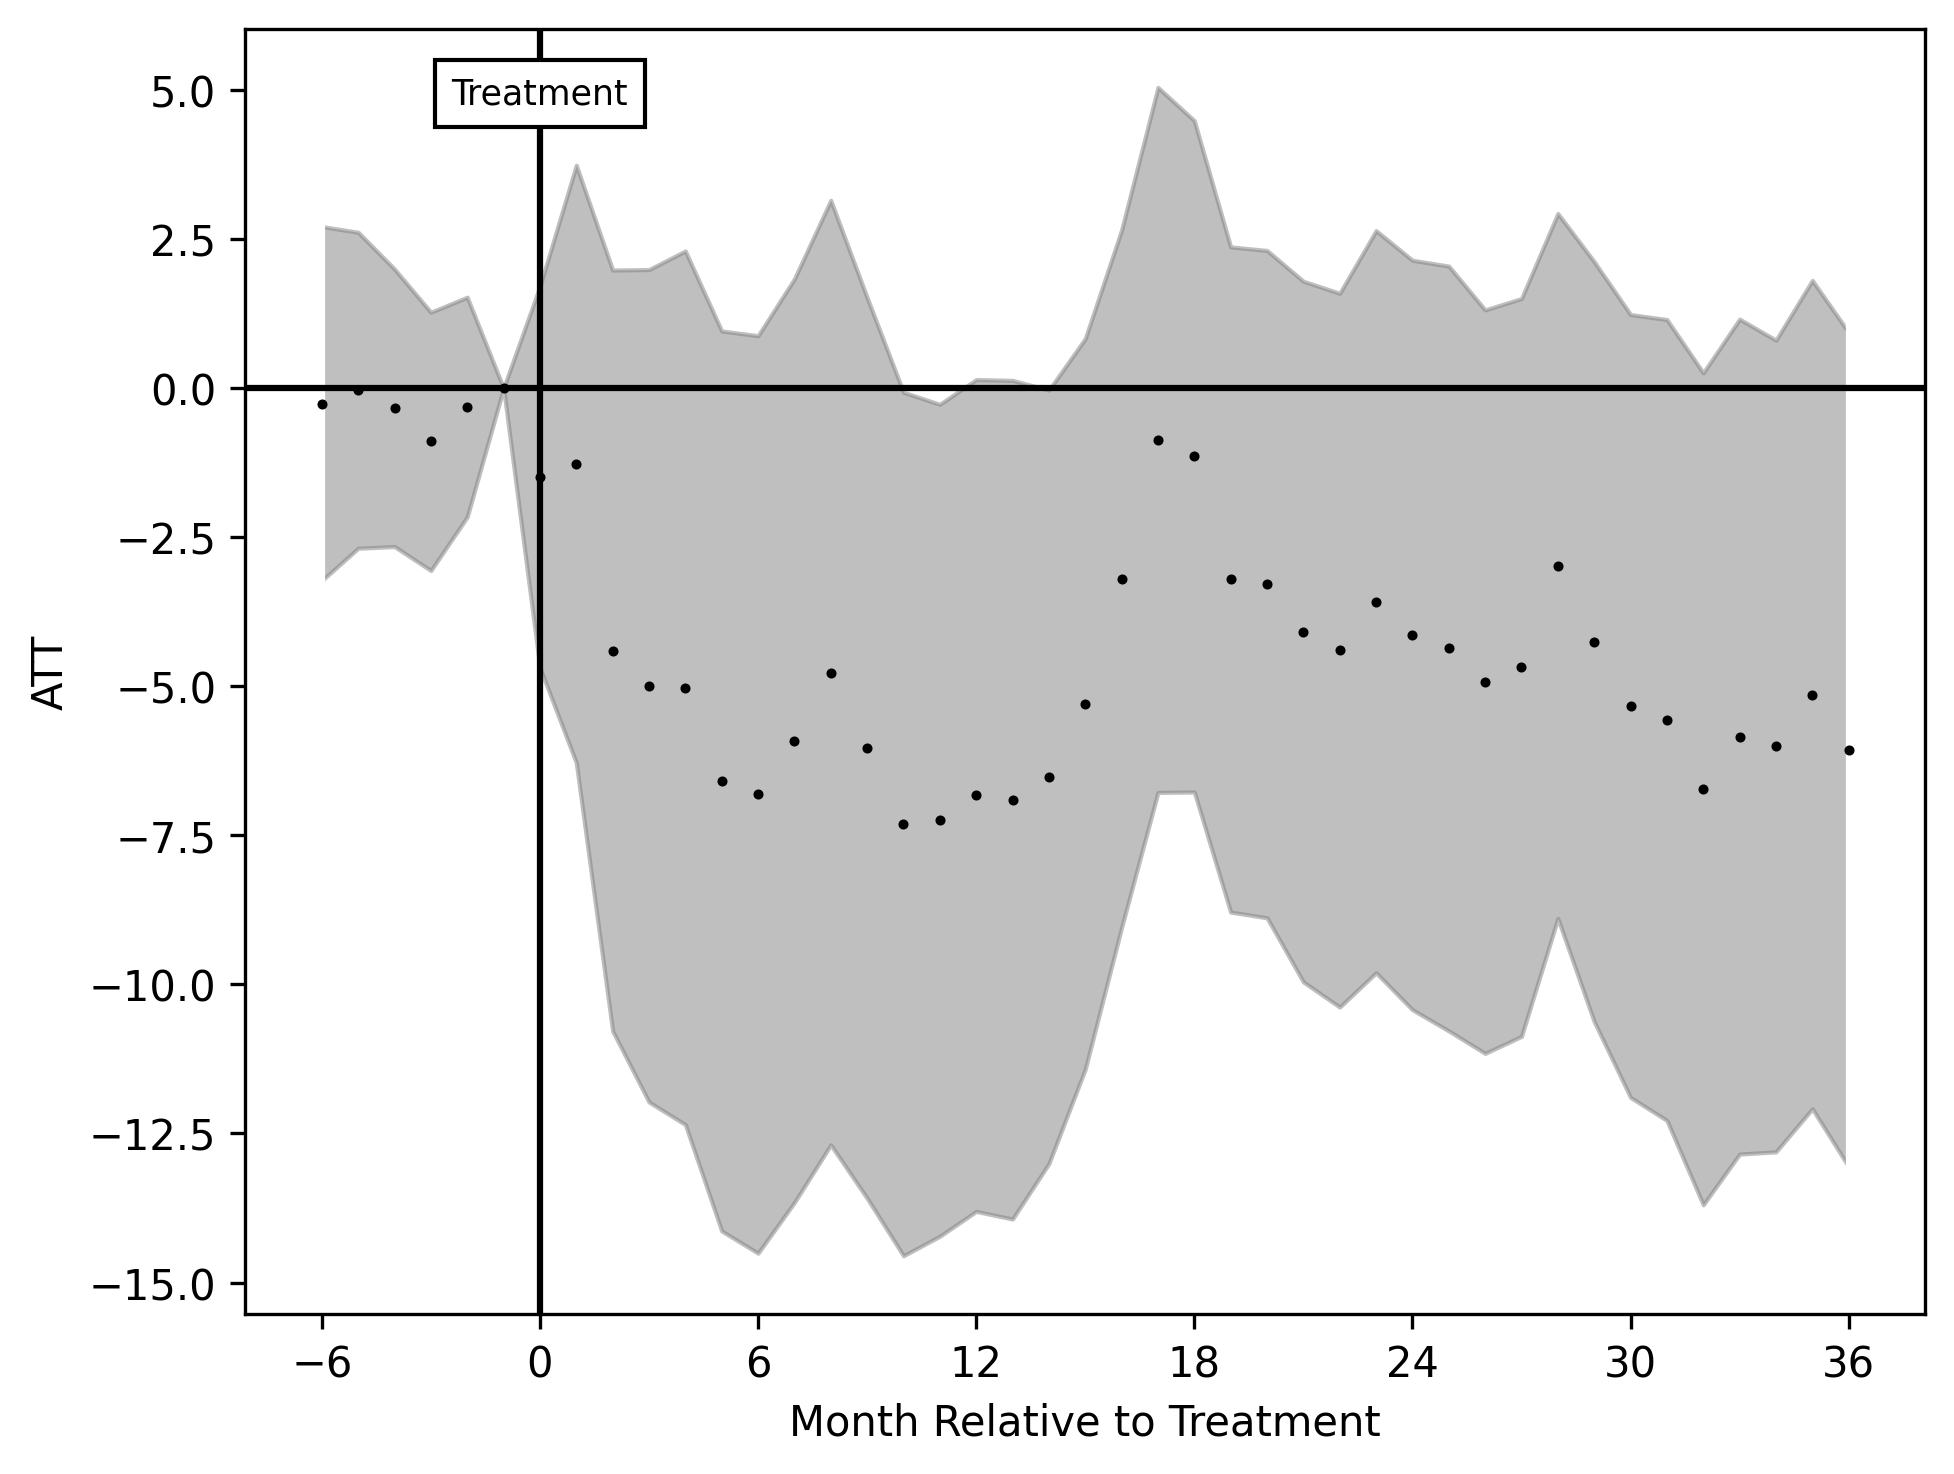

In [8]:
# Plot unconditional ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_unconditional_event_study_long_horizon.png",
                                 start_period=-6, end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)

In [9]:
# Run DiD conditional on covariates.
att_gt = ATTgt(data=df, cohort_name=treatment_date_variable, freq='M', base_period='universal')
formula = f'{analysis} ~ ' + '+'.join(pre_treatment_covariates)
result = att_gt.fit(formula=formula, control_group='never_treated', n_jobs=-1, progress_bar=True)

Computing ATTgt [workers=10]  100%|████████████████████| 368/368 [00:09<00:00, 37.75it/s]


-6.653897667091715
-5.155200894523972
-4.930488282954593
-0.23584642992326055


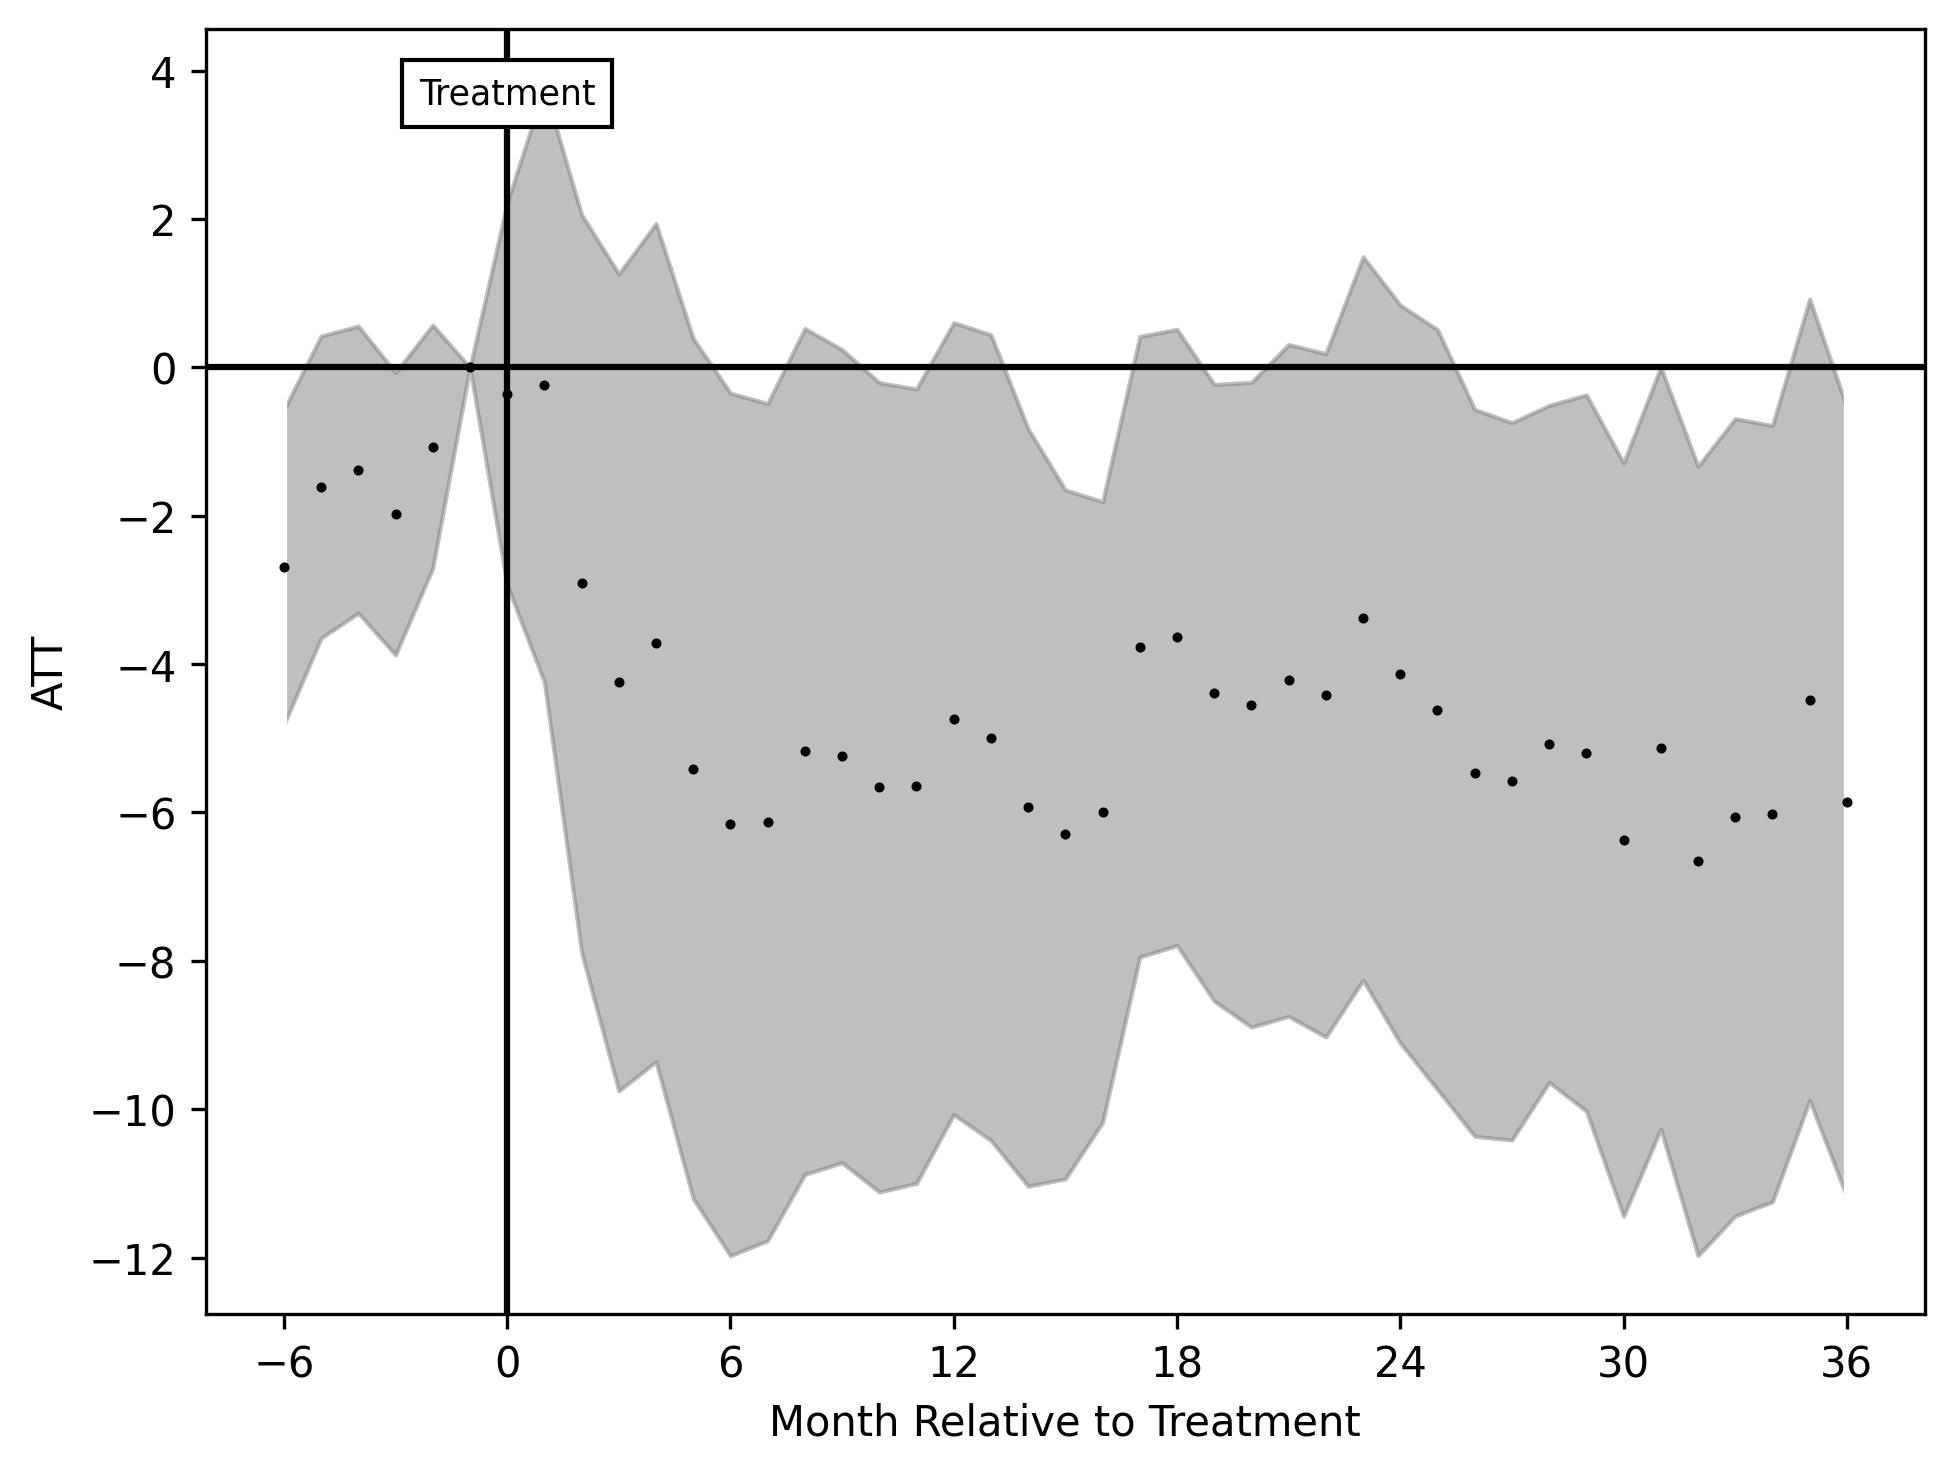

In [10]:
# Plot D.R. ATT(t-g)s on a long horizon.
aggregate_by_event_time_and_plot(att_gt, OUTPUT_FIGURES, "att_gt_dr_event_study_long_horizon.png", start_period=-6,
                                 end_period=36,
                                 title="",
                                 treatment_month_variable=treatment_date_variable, df=df)